# Set up

In [0]:
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

In [0]:
!pip install nltk

     |████████████████████████████████| 1.5 MB 10.8 MB/s 
     |████████████████████████████████| 78 kB 1.4 MB/s 
     |████████████████████████████████| 769 kB 83.3 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-13d8a2ad-0e32-4f07-a8bb-55b7c5d342c3/bin/python -m pip install --upgrade pip' command.


# Read the dataset

In [0]:
dbutils.fs.ls("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet")

Out[3]: [FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments/', name='comments/', size=0, modificationTime=1666557328000),
 FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions/', name='submissions/', size=0, modificationTime=1666559745000)]

In [0]:
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

# Prepare and Clean the dataset

create dataframe

In [0]:
# filter the columns we want to use
from pyspark.sql.functions import *

comment_content = comments.filter((col("subreddit")=='AskMen')|(col("subreddit")=='AskWomen')).cache()

comment_content = comment_content.select("body","subreddit",'created_utc')

comment_content.show(10)

+--------------------+---------+-----------+
|                body|subreddit|created_utc|
+--------------------+---------+-----------+
|We do not allow s...|   AskMen| 1624437156|
|congratulations. ...|   AskMen| 1624437166|
|Waste of a patent...|   AskMen| 1624437172|
|           [removed]|   AskMen| 1624437193|
|               Nope.|   AskMen| 1624437202|
|When I was lookin...|   AskMen| 1624437205|
|My god, man. 'I h...|   AskMen| 1624437211|
|I can't speak for...| AskWomen| 1624437224|
|boobs in face, st...|   AskMen| 1624437234|
|Thank you for  sh...|   AskMen| 1624437244|
+--------------------+---------+-----------+
only showing top 10 rows



change the time format

In [0]:
# change the format of the time
from pyspark.sql.functions import *
#comment_content_small = comment_content.sample(withReplacement=False, fraction=0.0000005)
#comment_content_small = comment_content_small.withColumn("created_utc", from_unixtime(col("created_utc"),"MM-dd-yyyy"))
#comment_content_small = comment_content_small.withColumn("created_utc",to_date(col("created_utc"),"MM-dd-yyyy"))
comment_content = comment_content.withColumn("created_utc", from_unixtime(col("created_utc"),"MM-dd-yyyy"))
comment_content = comment_content.withColumn("created_utc",to_date(col("created_utc"),"MM-dd-yyyy"))

In [0]:
# remove comments which length is less than 5 and greater than 500
from pyspark.sql.functions import length
from pyspark.sql.functions import *
comment_content = comment_content.where(length(col("body")) < 500)
comment_content = comment_content.where(length(col("body")) > 300)
comment_content.show(10)

+--------------------+---------+-----------+
|                body|subreddit|created_utc|
+--------------------+---------+-----------+
|So, what would yo...|   AskMen| 2021-06-23|
|Sounds like you'r...|   AskMen| 2021-06-23|
|every single pers...| AskWomen| 2021-06-23|
|* Waking up early...| AskWomen| 2021-06-23|
|In short, yes. \n...|   AskMen| 2021-06-23|
|A normal feeling ...| AskWomen| 2021-06-23|
|LOL definitely no...|   AskMen| 2021-06-23|
|Oh I feel this. I...| AskWomen| 2021-06-23|
|This happened to ...|   AskMen| 2021-06-23|
|Change and suffer...|   AskMen| 2021-06-23|
+--------------------+---------+-----------+
only showing top 10 rows



length distribution

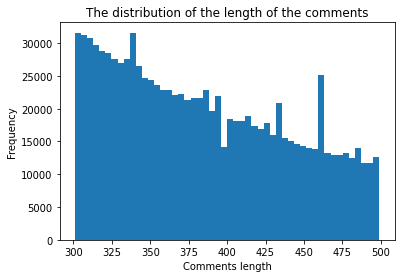

In [0]:
#check the length of the comment
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import os

df = comment_content.alias('df')
df = df.withColumn("length_of_comments", length("body"))

plt.hist(df.toPandas().length_of_comments, bins=50)
plt.title('The distribution of the length of the comments')
plt.xlabel('Comments length')
plt.ylabel('Frequency')
plot_fpath = os.path.join(PLOT_DIR, 'distribution_of_content_length.png')

plt.savefig(plot_fpath)

plt.show() 

In [0]:
comment_content.count()

Out[9]: 1016552

basic text cleaning

In [0]:
#comment_content_small=comment_content_small.withColumn('body', translate('body', '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~', ''))
cleaned_comment_content = comment_content.alias('cleaned_comment_content')
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '\&\w*;|#\w*;|@\w*', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '[^\w\s]', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '[0-9]', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', 'https?:\/\/.*\/\w*', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', 'RT|@', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '[-\.\n]', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '\s\s+', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', "^\\s+|\\s+$", ''))


# Find the most frequent word and the distribution of length

In [0]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel
import nltk
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
from sparknlp.base import Finisher
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler().setInputCol('body').setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('tokenized')

normalizer = Normalizer() \
    .setInputCols(['tokenized']) \
    .setOutputCol('normalized') \
    .setLowercase(True)
    
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemmatized')

nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemmatized']) \
    .setOutputCol('no_stop_lemmatized') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords)

finisher = Finisher() \
     .setInputCols(['no_stop_lemmatized']) \
     .setCleanAnnotations(False)

#from pyspark.ml import Pipeline
#pipeline = Pipeline().setStages([documentAssembler,tokenizer,normalizer,lemmatizer,stopwords_cleaner,finisher])
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           normalizer,
           lemmatizer,
           stopwords_cleaner,
           finisher
     ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
review_text = cleaned_comment_content
processed_review = pipeline.fit(review_text).transform(review_text)

find the top 30 most frequent words

In [0]:
words = processed_review.select('finished_no_stop_lemmatized').withColumn('exploded_text', explode(col('finished_no_stop_lemmatized')))
counts = words.select('exploded_text').groupby('exploded_text').count()
counts = counts.sort('count', ascending=False)
counts_df = counts.limit(30).toPandas()
fpath = os.path.join(CSV_DIR, "counts_word.csv")
counts_df.to_csv(fpath)
counts.show(30)

+-------------+------+
|exploded_text| count|
+-------------+------+
|          get|438594|
|         like|410584|
|         dont|331264|
|           im|312763|
|           go|291197|
|        think|279292|
|         make|274472|
|       people|251366|
|         time|241149|
|         want|231482|
|          one|226031|
|          say|223194|
|        woman|218529|
|         feel|211812|
|         know|210825|
|        would|203897|
|        thing|201887|
|         good|190311|
|          man|177421|
|         work|172661|
|       really|162744|
|         well|150707|
|          try|145455|
|         take|144399|
|          see|143974|
|       friend|142911|
|         even|137376|
|         look|135180|
|          way|131696|
|         life|128137|
+-------------+------+
only showing top 30 rows



find the most important word

In [0]:
!pip install gensim

     |████▊                           | 3.5 MB

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 24.0 MB 11.0 MB/s 
     |████████████████████████████████| 58 kB 8.1 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-13d8a2ad-0e32-4f07-a8bb-55b7c5d342c3/bin/python -m pip install --upgrade pip' command.


In [0]:
documents = processed_review.select(col("finished_no_stop_lemmatized")).toPandas().finished_no_stop_lemmatized.values.tolist()
#print(documents)

In [0]:
import gensim
dictionary = gensim.corpora.Dictionary(documents)
bow_corpus = []
for document in documents:
    bow_corpus.append(dictionary.doc2bow(document))
    
model = gensim.models.TfidfModel(bow_corpus) 
corpus_tfidf = model[bow_corpus]

In [0]:
def Sort(tfidf_tuples):
    tfidf_tuples.sort(key = lambda x: x[1], reverse=True)
    return tfidf_tuples 
result = {}
for n in range(len(corpus_tfidf)):
    most_significant_terms = Sort(corpus_tfidf[n])
    # Next we print the list, replacing the token ids with the tokens
    for id, score in most_significant_terms:
        if dictionary[id] not in result.keys():
            result[dictionary[id]] = score
        else:
            result[dictionary[id]] += score

In [0]:
result

Out[18]: {'choose': 2290.0828132646407,
 'timeso': 35.63326184134764,
 'coordinate': 72.18644360351857,
 'alcoholic': 338.22133345186967,
 'technically': 408.6862014972716,
 'initiate': 807.2961973788082,
 'lunch': 725.2485749763796,
 'suggest': 1181.321021566516,
 'something': 9303.397340423055,
 'whether': 1778.5377335137553,
 'bar': 2061.023852835715,
 'drink': 3854.2298584902533,
 'eat': 3496.474497254905,
 'situation': 4135.432432272513,
 'place': 4285.616872724161,
 'nice': 4717.865086274596,
 'let': 5362.841724904162,
 'date': 8619.983637631276,
 'first': 6940.508055477927,
 'ask': 9775.050200616382,
 'day': 8837.662971348738,
 'get': 16134.31734470255,
 'woman': 13958.103132180457,
 'would': 12623.120634426637,
 'im': 15578.59997542067,
 'reallysome': 1.4438929342818756,
 'dontyour': 3.2545840869851674,
 'problem': 4476.536463284158,
 'blowjob': 310.98030615560515,
 'alternative': 347.1061519373125,
 'alright': 435.2319323720737,
 'solve': 723.3416307545905,
 'communicate': 132

create dummy variable

In [0]:
cleaned_comment_content = cleaned_comment_content.withColumn("survey_comments", \
   when((cleaned_comment_content.body.rlike("survey")), lit(1)) \
     .otherwise(lit(0)) \
  )
cleaned_comment_content = cleaned_comment_content.withColumn("promotional_comments", \
   when((cleaned_comment_content.body.rlike("promotional")), lit(1)) \
     .otherwise(lit(0)) \
  )

# Sentiment Analysis

create a pipeline

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import json
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

documentAssembler = DocumentAssembler()\
    .setInputCol("body")\
    .setOutputCol("document")
    
token = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

vivekn =  ViveknSentimentModel.pretrained() \
    .setInputCols(["document", "normal"]) \
    .setOutputCol("result_sentiment")

finisher = Finisher() \
    .setInputCols(["result_sentiment"]) \
    .setOutputCols("final_sentiment")

pipeline = Pipeline().setStages([documentAssembler, token, normalizer, vivekn, finisher])

sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]


fit the model

In [0]:
data = cleaned_comment_content
pipelineModel = pipeline.fit(data)
result = pipelineModel.transform(data)
result = result.filter(array_contains(col("final_sentiment"), "positive") | array_contains(col("final_sentiment"), "negative"))

result.show(10)

+--------------------+---------+-----------+---------------+--------------------+---------------+
|                body|subreddit|created_utc|survey_comments|promotional_comments|final_sentiment|
+--------------------+---------+-----------+---------------+--------------------+---------------+
|So what would you...|   AskMen| 2021-06-23|              0|                   0|     [positive]|
|Sounds like youre...|   AskMen| 2021-06-23|              0|                   0|     [negative]|
|every single pers...| AskWomen| 2021-06-23|              0|                   0|     [negative]|
|Waking up early E...| AskWomen| 2021-06-23|              0|                   0|     [negative]|
|In short yes I do...|   AskMen| 2021-06-23|              0|                   0|     [positive]|
|A normal feeling ...| AskWomen| 2021-06-23|              0|                   0|     [negative]|
|LOL definitely no...|   AskMen| 2021-06-23|              0|                   0|     [positive]|
|Oh I feel this I ..

# Count the number of postive and negative comments for each subreddits

In [0]:
sentiment_count_by_subreddit = result.groupBy(['subreddit','final_sentiment']).count().orderBy(col('count'))
positive_count_by_subreddit = sentiment_count_by_subreddit.filter(array_contains(col("final_sentiment"), "positive"))
negative_count_by_subreddit = sentiment_count_by_subreddit.filter(array_contains(col("final_sentiment"), "negative"))

### show top 10 most number of postive comments subreddits ###

In [0]:
positive_count_by_subreddit_df = positive_count_by_subreddit.toPandas()
fpath = os.path.join(CSV_DIR, "positive_count_by_subreddit.csv")
positive_count_by_subreddit_df.to_csv(fpath)
positive_count_by_subreddit.show()

+---------+---------------+------+
|subreddit|final_sentiment| count|
+---------+---------------+------+
| AskWomen|     [positive]|143400|
|   AskMen|     [positive]|320938|
+---------+---------------+------+



### show top 10 most number of negative comments subreddits ###

In [0]:
negative_count_by_subreddit_df = negative_count_by_subreddit.toPandas()
fpath = os.path.join(CSV_DIR, "negative_count_by_subreddit.csv")
negative_count_by_subreddit_df.to_csv(fpath)
negative_count_by_subreddit.show(10)

+---------+---------------+------+
|subreddit|final_sentiment| count|
+---------+---------------+------+
| AskWomen|     [negative]|150445|
|   AskMen|     [negative]|401601|
+---------+---------------+------+



### Time Series ###

In [0]:
sentiment_count = result.groupBy(['created_utc','final_sentiment']).count().orderBy(col('created_utc'))
positive_count = sentiment_count.filter(array_contains(col("final_sentiment"), "positive")).toPandas()
negative_count = sentiment_count.filter(array_contains(col("final_sentiment"), "negative")).toPandas()

# Merge dataframe with external source to find the relationship between stock price and number of postive comments

In [0]:
Nasdaq = pd.read_csv("/dbfs/FileStore/finance.csv")
Nasdaq['Date']= pd.to_datetime(Nasdaq['Date']).dt.date
new_df = pd.merge(Nasdaq, positive_count, how='left', left_on='Date', right_on='created_utc')
new_df = new_df.drop('created_utc', axis=1)
new_df = new_df.drop('final_sentiment',axis=1)
new_df.iloc[:,1:8] = new_df.iloc[:,1:8].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [0]:
new_df.head()

Date 
 Open 
 High 
 Low 
 Close 
 Adj Close 
 Volume 
 count 
 
 
 
 
 0 
 2021-01-04 
 -0.645849 
 -0.744259 
 -0.865455 
 -0.850890 
 -0.850890 
 1.329069 
 -0.525759 
 
 
 1 
 2021-01-05 
 -0.877991 
 -0.849596 
 -0.769488 
 -0.755131 
 -0.755131 
 1.650360 
 -0.813740 
 
 
 2 
 2021-01-06 
 -0.877595 
 -0.783899 
 -0.781765 
 -0.817246 
 -0.817246 
 2.318595 
 -0.411654 
 
 
 3 
 2021-01-07 
 -0.718123 
 -0.637517 
 -0.611366 
 -0.557653 
 -0.557653 
 1.535912 
 -1.520109 
 
 
 4 
 2021-01-08 
 -0.485972 
 -0.542896 
 -0.478708 
 -0.450777 
 -0.450777 
 1.937121 
 -1.090854

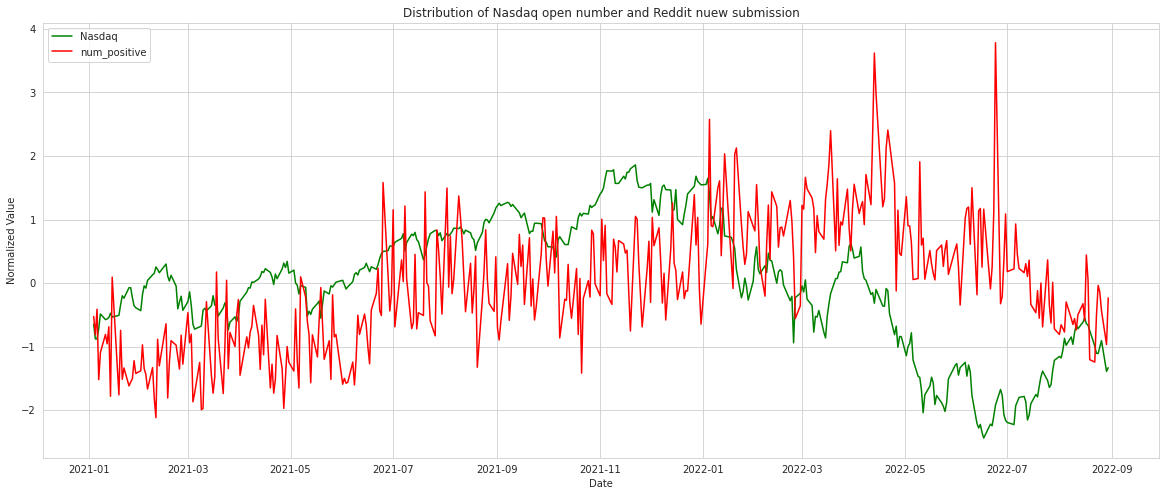

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
time = new_df['Date'].to_list()
open = new_df['Open'].to_list()
count = new_df['count'].to_list()

# set the seaborn style
sns.set_style("whitegrid")
 
# Color palette
blue, = sns.color_palette("muted", 1)
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(20, 8))
# Plot lines
ax.plot(time, open, color="green", label = 'Nasdaq')
ax.plot(time, count, color="red", label = 'num_positive')
ax.legend(loc = 'upper left')
ax.set_title('Distribution of Nasdaq open number and Reddit nuew submission')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Value')
plot_fpath = os.path.join(PLOT_DIR, 'Positive_Distribution.png')

fig.savefig(plot_fpath)

fig.show()

# Merge dataframe with external source to find the relationship between stock price and number of negative comments

In [0]:
new_df2 = pd.merge(Nasdaq, negative_count, how='left', left_on='Date', right_on='created_utc')
new_df2 = new_df2.drop('created_utc', axis=1)
new_df2 = new_df2.drop('final_sentiment',axis=1)
new_df2.iloc[:,1:8] = new_df2.iloc[:,1:8].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

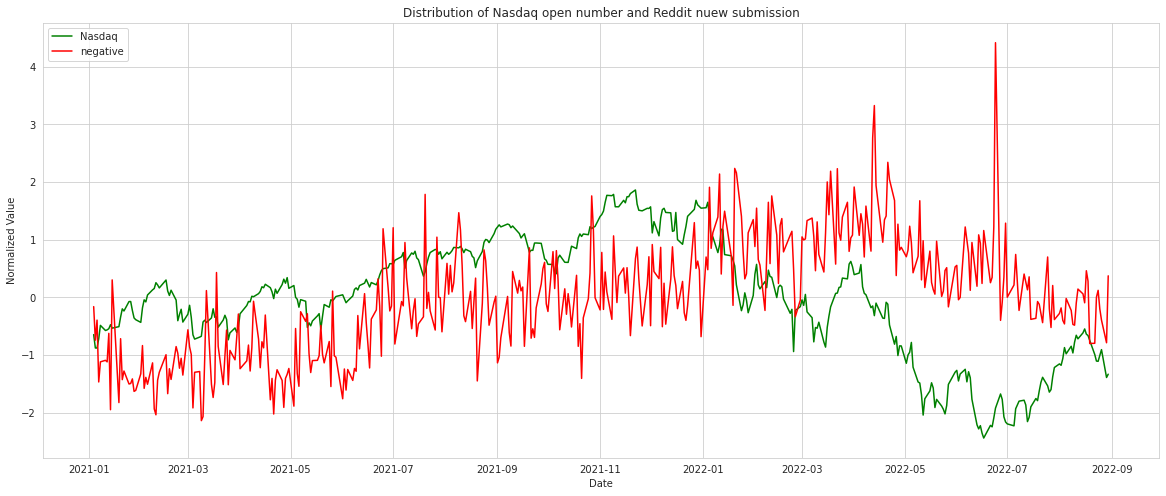

In [0]:
import seaborn as sns
time = new_df2['Date'].to_list()
open = new_df2['Open'].to_list()
count = new_df2['count'].to_list()

# set the seaborn style
sns.set_style("whitegrid")
 
# Color palette
blue, = sns.color_palette("muted", 1)
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(20, 8))
# Plot lines
ax.plot(time, open, color="green", label = 'Nasdaq')
ax.plot(time, count, color="red", label = 'negative')
ax.legend(loc = 'upper left')
ax.set_title('Distribution of Nasdaq open number and Reddit nuew submission')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Value')
plot_fpath = os.path.join(PLOT_DIR, 'Negative_Distribution.png')

fig.savefig(plot_fpath)

fig.show()

# Text Classification

In [0]:
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [0]:
from pyspark.sql import functions as F
commentsm_small = cleaned_comment_content.select(cleaned_comment_content.body,cleaned_comment_content.created_utc,cleaned_comment_content.subreddit).filter("subreddit = 'AskMen'")
commentsm_small.count()

Out[6]: 722682

In [0]:
commentsw_small = cleaned_comment_content.select(cleaned_comment_content.body,cleaned_comment_content.created_utc,cleaned_comment_content.subreddit).filter("subreddit = 'AskWomen'")
#commentsw_small.count()

In [0]:
commentsm_small = commentsm_small.toPandas()
commentsm_small.head()

body 
 created_utc 
 subreddit 
 
 
 
 
 0 
 So what would you do in this situation Im the ... 
 2021-06-23 
 AskMen 
 
 
 1 
 Sounds like youre pretty normal reallySome guy... 
 2021-06-23 
 AskMen 
 
 
 2 
 In short yes I dont like to get into familywor... 
 2021-06-23 
 AskMen 
 
 
 3 
 LOL definitely not gay my friend Im sorry to d... 
 2021-06-23 
 AskMen 
 
 
 4 
 This happened to me she was just waiting for h... 
 2021-06-23 
 AskMen

In [0]:
commentsw_small = commentsw_small.toPandas()
commentsw_small.head()

body 
 created_utc 
 subreddit 
 
 
 
 
 0 
 every single person i tried fwb with either ca... 
 2021-06-23 
 AskWomen 
 
 
 1 
 Waking up early Exercising during the day Dark... 
 2021-06-23 
 AskWomen 
 
 
 2 
 A normal feeling even in a healthy relationshi... 
 2021-06-23 
 AskWomen 
 
 
 3 
 Oh I feel this I definitely settled for my exh... 
 2021-06-23 
 AskWomen 
 
 
 4 
 When I was a teenager my Mum wanted me to take... 
 2021-06-23 
 AskWomen

In [0]:
#Remove rows with null values
commentsm_small.dropna(inplace=True)
commentsw_small.dropna(inplace=True)

#Remove comments with the same ID
#commentsm_small.drop_duplicates('id',inplace=True)
#commentsw_small.drop_duplicates('id',inplace=True)

In [0]:
#Removing deleted comments and moderator comments from AskMen
commentsm_small = commentsm_small[commentsm_small['body']!='[deleted]']
commentsm_small = commentsm_small[commentsm_small['body']!='\\[removed\]']
commentsm_small = commentsm_small[commentsm_small['body']!='[removed]']



#Removing deleted comments and moderator comments from AskWomen
commentsw_small = commentsw_small[commentsw_small['body']!='[deleted]']
commentsw_small = commentsw_small[commentsw_small['body']!='\\[removed\]']
commentsw_small = commentsw_small[commentsw_small['body']!='[removed]']


In [0]:
commentsm_small.shape

Out[38]: (722682, 3)

In [0]:
commentsw_small.shape

Out[39]: (293870, 3)

In [0]:
import pandas as pd
comments_gender = pd.concat([commentsm_small, commentsw_small])
comments_gender = comments_gender.reset_index(drop=True)
comments_gender.head()

body 
 created_utc 
 subreddit 
 
 
 
 
 0 
 So what would you do in this situation Im the ... 
 2021-06-23 
 AskMen 
 
 
 1 
 Sounds like youre pretty normal reallySome guy... 
 2021-06-23 
 AskMen 
 
 
 2 
 In short yes I dont like to get into familywor... 
 2021-06-23 
 AskMen 
 
 
 3 
 LOL definitely not gay my friend Im sorry to d... 
 2021-06-23 
 AskMen 
 
 
 4 
 This happened to me she was just waiting for h... 
 2021-06-23 
 AskMen

In [0]:
len(comments_gender['body'].map(lambda x: x if '\r' in x else 0).unique())

Out[13]: 17

In [0]:
#Import Regex
import re

#This function selects any consecutive combination of \r's and \n's in a bloc of text, 
#and replaces that selection with a single space.
def replace_linebreaks_w_space(x):
	return re.sub('([\r\n]+)',' ',x)

#This function selects any stretch of two or more consecutive spaces in a bloc of text,
#and replaces that selection with a single space.
def replace_multispace_w_space(x):
	return re.sub('([ ]{2,})',' ',x)

#Here we take every comment and apply the two functions to it.
comments_gender['body'] = comments_gender['body'].map(replace_linebreaks_w_space)
comments_gender['body'] = comments_gender['body'].map(replace_multispace_w_space)

comments_gender['word_length'] = comments_gender['body'].map(lambda x: len(x.strip().split(' ')))
#comments_gender.head()

In [0]:
comments_gender = comments_gender[comments_gender['word_length']>=50]
len(comments_gender)

comments_gender['subreddit'].value_counts()

#comments_gender.to_csv('comments_gender_final.csv',index=False)

Out[20]: AskMen      705040
AskWomen    281171
Name: subreddit, dtype: int64

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [0]:
comments_men = comments_gender[comments_gender['subreddit'] == 'AskMen'][:10000]
comments_women = comments_gender[comments_gender['subreddit'] == 'AskWomen'][:10000]
comments_gender_new = pd.concat([comments_men, comments_women])
comments_gender_new['subreddit'].value_counts()

Out[22]: AskMen      10000
AskWomen    10000
Name: subreddit, dtype: int64

In [0]:
#Separate data into comment text (features) and subreddit (target variable)
X = comments_gender_new['body']
y = comments_gender_new['subreddit']

#Train test split. Stratify=y guarantees that class balance will be maintained across train and test bloc
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,stratify=y)

In [0]:
#Creates pipeline to handle vectorization and logistic regression steps
pipe = Pipeline([
	('vect', CountVectorizer()),
	('model', LogisticRegression())
	 ])

#Specifies different hyperparameter values that we want to test across
params = {
	'vect__ngram_range':[(1,3)],
	'vect__min_df':[2,5],
	'vect__stop_words':[None,'english'],
	'model__penalty':['l2','l1'],
	'model__C':[0.1, 1, 10],
}

#Executes GridSearch
gs_lr1 = GridSearchCV(pipe, params, cv=4, verbose=3, n_jobs=-1)
gs_lr1.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
/databricks/python/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72293333 0.7106     0.71873333 0.7068            nan        nan
        nan        nan 0.71613333 0.7012     0.70546667 0.68506667
        nan        nan        nan        nan 0.71226667 0.69246667
 0.70013333 0.66806667        nan        nan        nan        nan]
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optim

In [0]:
#Training data accuracy score
gs_lr1.score(X_train, y_train)

Out[27]: 0.9958

In [0]:
#Test data accuracy score
gs_lr1.score(X_test, y_test)

Out[28]: 0.7304

In [0]:
#Shows us which hyperparameters were chosen
gs_lr1.best_estimator_.steps

Out[29]: [('vect', CountVectorizer(min_df=2, ngram_range=(1, 3))),
 ('model', LogisticRegression(C=0.1))]

In [0]:
pipe2 = Pipeline([
	('vect', TfidfVectorizer()),
	('model', LogisticRegression())
	 ])

params = {
	'vect__ngram_range':[(1,3)],
	'vect__min_df':[2,5],
	'vect__stop_words':[None,'english'],
	'model__penalty':['l2','l1'],
	'model__C':[0.1, 1, 10],
}

gs_lr2 = GridSearchCV(pipe2, params, cv=4, verbose=2, n_jobs=-1)
gs_lr2.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
/databricks/python/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.6958     0.6998     0.69866667 0.69893333        nan        nan
        nan        nan 0.7246     0.71433333 0.72553333 0.71046667
        nan        nan        nan        nan 0.72753333 0.70953333
 0.71813333 0.6956            nan        nan        nan        nan]
  warnings.warn(
Out[30]: GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__penalty': ['l2', 'l1'], 'vect__min_df': [2, 5],
                         'vect__ngram_range': [(1, 3)],
                         'vect__stop_words': [None, 'english']},
             verbose=2)

In [0]:
#Training data score
gs_lr2.score(X_train, y_train)

Out[31]: 0.9998

In [0]:
#Test data score
gs_lr2.score(X_test, y_test)

Out[32]: 0.7426

In [0]:
#Shows which hyperparameters were chosen
gs_lr2.best_estimator_.steps

Out[33]: [('vect', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
 ('model', LogisticRegression(C=10))]

In [0]:
def fancy_confusion_matrix(y_test, preds):

	cmat = confusion_matrix(y_test, preds)
	print(f'Accuracy: {accuracy_score(y_test, preds)}')
	print(classification_report(y_test, preds))
	return pd.DataFrame(cmat, columns=['Predicted ' + str(i) for i in ['AskMen','AskWomen']],\
					index=['Actual ' + str(i) for i in ['AskMen','AskWomen']])

predicts = gs_lr2.predict(X_test)
fancy_confusion_matrix(y_test, predicts)

Accuracy: 0.7426
              precision    recall  f1-score   support

      AskMen       0.74      0.74      0.74      2500
    AskWomen       0.74      0.74      0.74      2500

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



Predicted AskMen 
 Predicted AskWomen 
 
 
 
 
 Actual AskMen 
 1862 
 638 
 
 
 Actual AskWomen 
 649 
 1851

In [0]:
coefs = pd.DataFrame(gs_lr2.best_estimator_.steps[1][1].coef_).T
coefs.columns = ['coef']
coefs['ngram'] = gs_lr2.best_estimator_.steps[0][1].get_feature_names()
coefs = coefs[['ngram','coef']]
coefs = coefs.sort_values('coef')

#Shows words and n-grams most strongly associated with comments by men
coefs.head(15)

ngram 
 coef 
 
 
 
 
 158157 
 wife 
 -10.297090 
 
 
 89825 
 my wife 
 -9.019451 
 
 
 52192 
 guys 
 -6.465919 
 
 
 116544 
 shit 
 -6.304146 
 
 
 49316 
 gf 
 -5.989241 
 
 
 163267 
 you 
 -5.525910 
 
 
 106385 
 porn 
 -5.485933 
 
 
 49400 
 girl 
 -5.244716 
 
 
 81311 
 man 
 -5.222927 
 
 
 47510 
 fuck 
 -4.864103 
 
 
 31126 
 dad 
 -4.843281 
 
 
 47592 
 fucking 
 -4.819534 
 
 
 49504 
 girlfriend 
 -4.777539 
 
 
 160475 
 women 
 -4.732603 
 
 
 66661 
 is 
 -4.485352

In [0]:
len(coefs)

In [0]:
from wordcloud import WordCloud

AskMenWordCloud = coefs[0:200]
AskWomenWordCloud = coefs.sort_values('coef',ascending=False)[0:200]

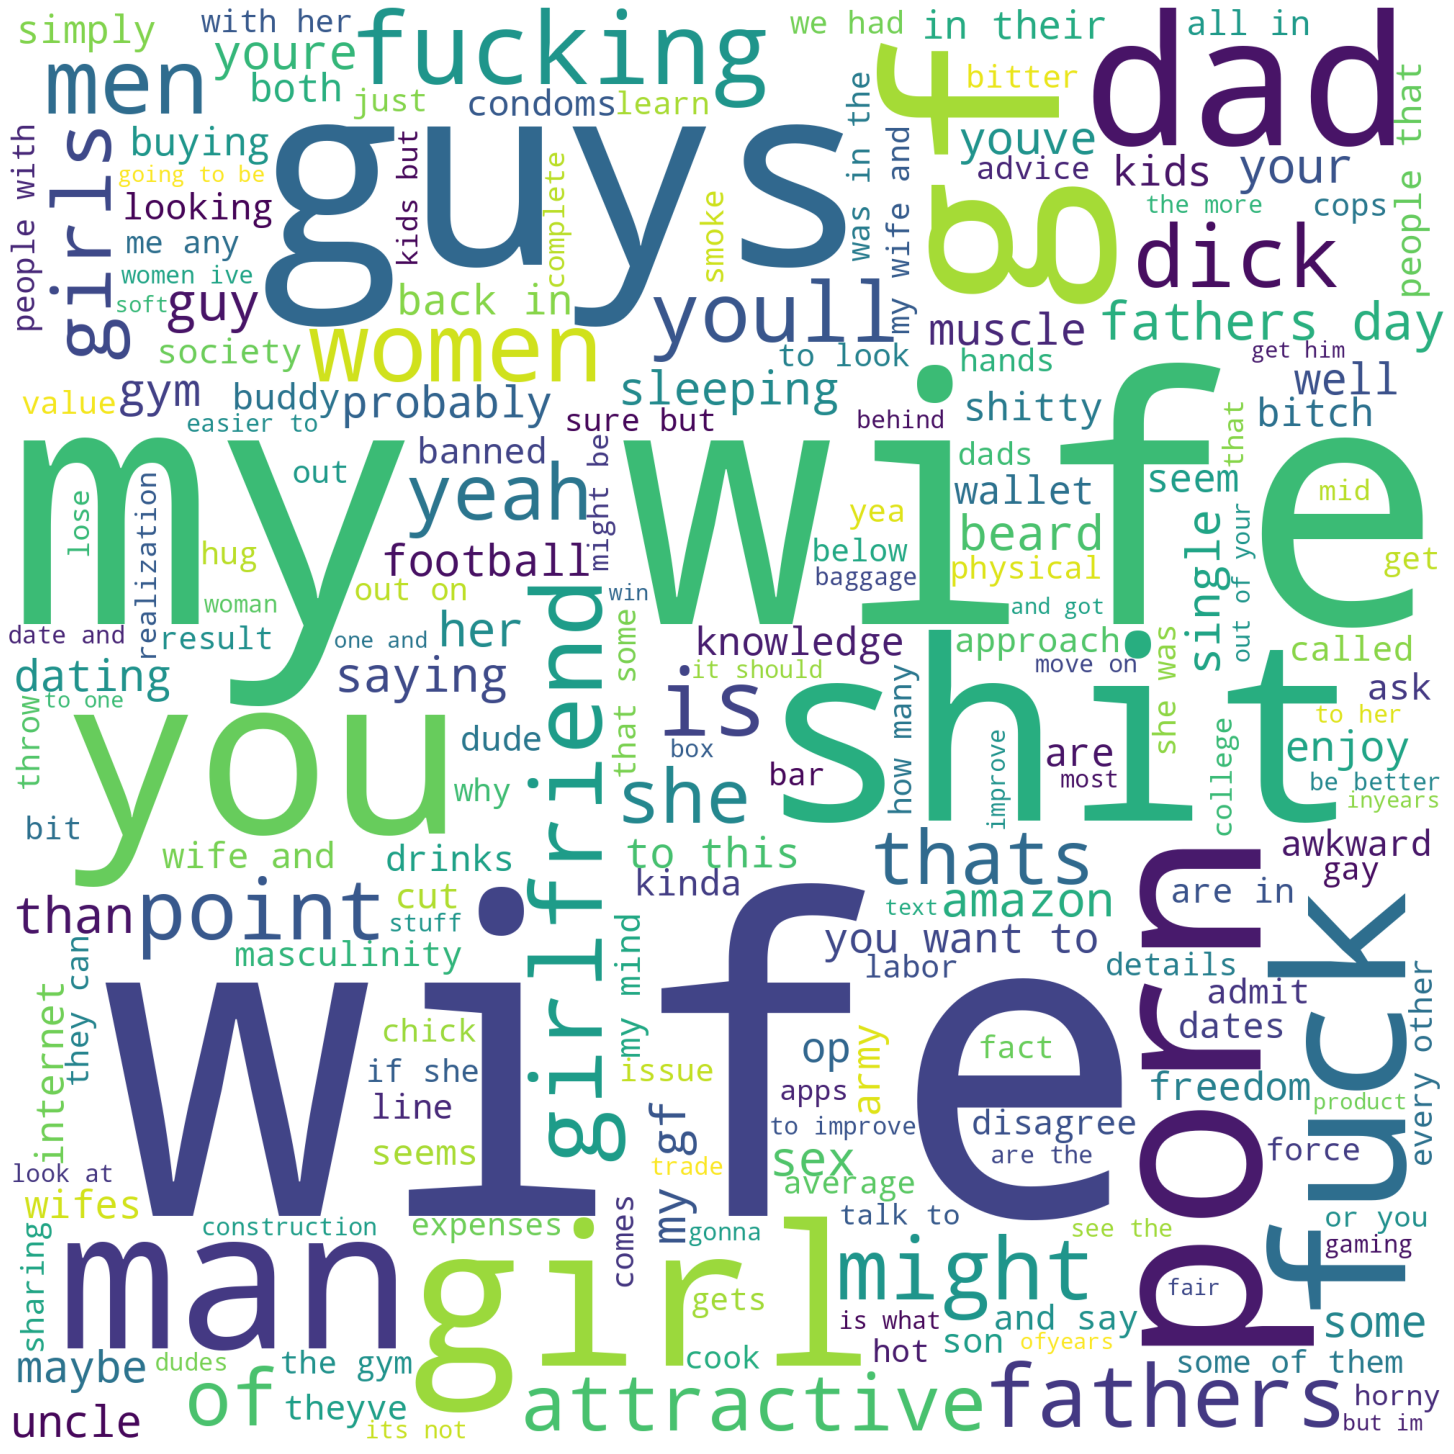

In [0]:
import matplotlib.pyplot as plt
#How to create a wordcloud:
d={}
for key, val in AskMenWordCloud.values:
	d[key] = int(val**2)

wordcloud = WordCloud(width = 2000, height = 2000,
							background_color ='white',
							min_font_size = 10).generate_from_frequencies(d)

plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plot_fpath = os.path.join(PLOT_DIR, 'AskMenWordCloud.png')

plt.savefig(plot_fpath)
plt.show()

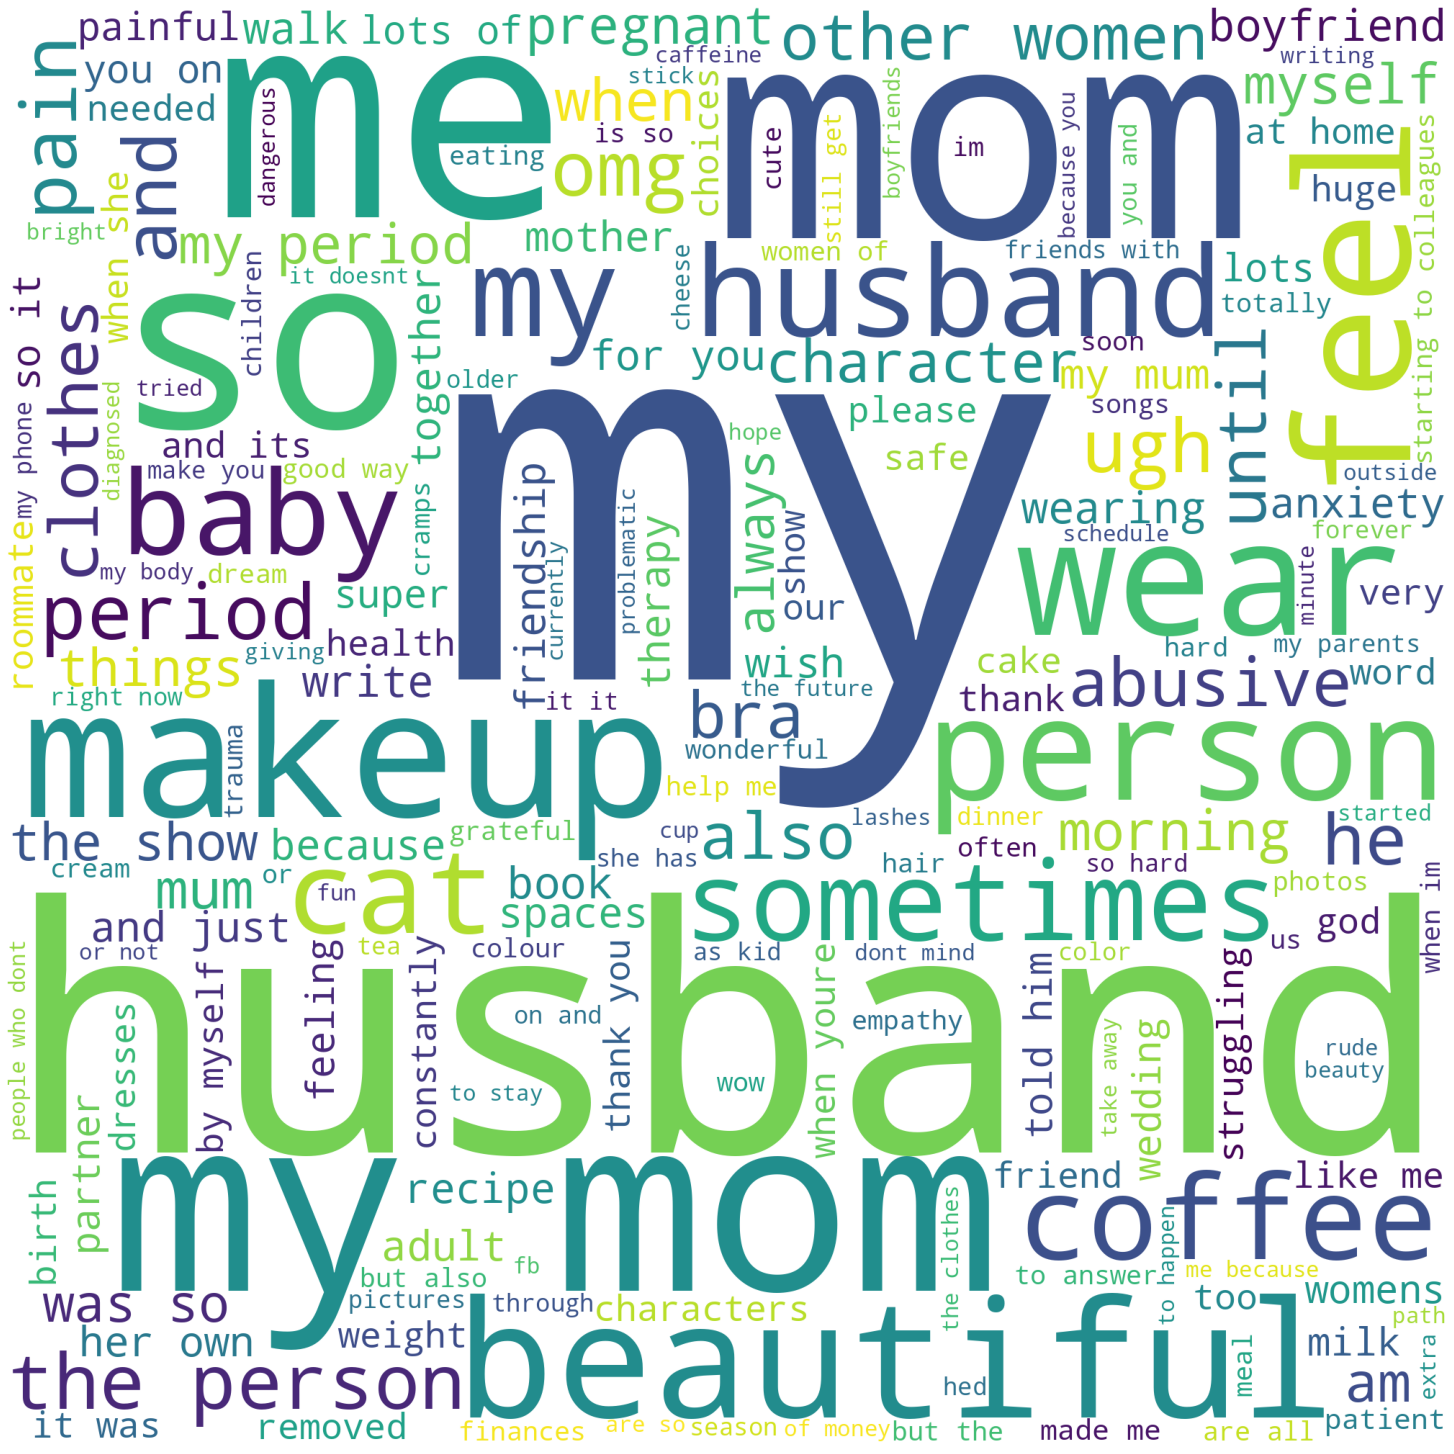

In [0]:
d={}
for key, val in AskWomenWordCloud.values:
	d[key] = int(val**2)

wordcloud = WordCloud(width = 2000, height = 2000,
							background_color ='white',
							min_font_size = 10).generate_from_frequencies(d)

plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plot_fpath = os.path.join(PLOT_DIR, 'AskWomenWordCloud.png')

plt.savefig(plot_fpath)
plt.show()

In [0]:
#Puts predicted probabilities and associated text into a dataframe
predictions = pd.DataFrame(gs_lr2.predict_proba(X))
predictions['text'] = comments_gender['body']
#Shows the top AskMen predicted comments
predictions.sort_values(1)[0:25]

0 
 1 
 text 
 
 
 
 
 4487 
 0.997570 
 0.002430 
 I didnt fall in love with my gf but I grew int... 
 
 
 1777 
 0.995685 
 0.004315 
 Not specific to women but Never invite yoursel... 
 
 
 3796 
 0.995440 
 0.004560 
 I woke up and thought I saw big foot Turns out... 
 
 
 7568 
 0.995404 
 0.004596 
 SameThats actually what prompted me to changeI... 
 
 
 8320 
 0.995266 
 0.004734 
 Had a stupid amount of success when it happene... 
 
 
 7971 
 0.994736 
 0.005264 
 Men whos dynamic range of speaking only goes f... 
 
 
 4633 
 0.994736 
 0.005264 
 My experience We dont talk about our wives of ... 
 
 
 7980 
 0.994736 
 0.005264 
 You nailed cook not just regular dishes really... 
 
 
 978 
 0.994736 
 0.005264 
 Yeah I never claimed the pedophile part at all... 
 
 
 1123 
 0.994736 
 0.005264 
 I was pretty much in the childfree camp until ... 
 
 
 2763 
 0.994736 
 0.005264 
 I was born with two fully functional penises r... 
 
 
 5885 
 0.994736 
 0.005264 
 No Why would I be open about it There is no po... 
 
 
 4648 
 0.994736 
 0.005264 
 Motorcycles are only dangerous if youre an idi... 
 
 
 7990 
 0.994736 
 0.005264 
 Dude at least you are honest I think maybe for... 
 
 
 6959 
 0.994736 
 0.005264 
 When a friend moved in and I saw heard how he ... 
 
 
 7968 
 0.994736 
 0.005264 
 Yeah so that is why neither party should get p... 
 
 
 9260 
 0.994736 
 0.005264 
 NaN 
 
 
 9207 
 0.994736 
 0.005264 
 First thought Hey I wonder if my track record ... 
 
 
 2770 
 0.994736 
 0.005264 
 Nope Having a partner that can provide for her... 
 
 
 6395 
 0.994736 
 0.005264 
 A failed marriage generally has far more negat... 
 
 
 6388 
 0.994736 
 0.005264 
 In my late s I decided to go back to school fo... 
 
 
 3922 
 0.994736 
 0.005264 
 I mean im not white either but thats never bee... 
 
 
 3920 
 0.994736 
 0.005264 
 Its all about the extremes of relatively norma... 
 
 
 2669 
 0.994736 
 0.005264 
 My wifes family is catty when it comes to mone... 
 
 
 3869 
 0.994736 
 0.005264 
 Its not just women who pull that shit I was on...

In [0]:
predictions = pd.DataFrame(gs_lr2.predict_proba(X))
predictions['text'] = comments_gender['body']
predictions['true'] = comments_gender['subreddit']
predictions['pred'] = gs_lr2.predict(X)
predictions.columns = ['AskMen','AskWomen','text','true','pred']
predictions = predictions[['text','true','pred','AskMen','AskWomen']]

In [0]:
#Let's look at comments where the model guessed wrong.
wrong = predictions[predictions['true']!=predictions['pred']]

In [0]:
#Predicts AskMen strongly when the answer is AskWomen
wrong.sort_values('AskMen',ascending=False).head(10)

text 
 true 
 pred 
 AskMen 
 AskWomen 
 
 
 
 
 36 
 NaN 
 NaN 
 AskMen 
 0.994736 
 0.005264 
 
 
 9260 
 NaN 
 NaN 
 AskMen 
 0.994736 
 0.005264 
 
 
 3265 
 NaN 
 NaN 
 AskMen 
 0.986923 
 0.013077 
 
 
 9691 
 NaN 
 NaN 
 AskMen 
 0.984764 
 0.015236 
 
 
 2800 
 NaN 
 NaN 
 AskMen 
 0.983284 
 0.016716 
 
 
 60 
 NaN 
 NaN 
 AskMen 
 0.982757 
 0.017243 
 
 
 8136 
 NaN 
 NaN 
 AskMen 
 0.979812 
 0.020188 
 
 
 4260 
 NaN 
 NaN 
 AskMen 
 0.979369 
 0.020631 
 
 
 6539 
 NaN 
 NaN 
 AskMen 
 0.979118 
 0.020882 
 
 
 965 
 NaN 
 NaN 
 AskMen 
 0.979060 
 0.020940

In [0]:
#Predicts AskWomen strongly when the answer is AskMen
wrong.sort_values('AskWomen',ascending=False)[100:120]

text 
 true 
 pred 
 AskMen 
 AskWomen 
 
 
 
 
 18662 
 It depends on your schedule and what you want ... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 10183 
 Ill add to this may sound obvious butCook with... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 10184 
 I dont Well at least not all of them Just beca... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 10185 
 I regret to this day when we were on a vacatio... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 10186 
 since Ill already have the state pension byMy ... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 18041 
 I have the same problem Its a mental comfort t... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 18685 
 I started looking at entrepreneurship and inve... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 13277 
 Wait whats wrong with DoveAlso you said Tilamo... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 13268 
 Id only care in two cases If shes had a very l... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 18000 
 Damn Living a version of this now Weve been to... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 13264 
 It is not just ditching the birth control it i... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 14642 
 I appreciate your honesty and courage to say t... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 13545 
 I feel that my current girlfriend is horrible ... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 18571 
 Get a stress ball and carry it with you when y... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 18464 
 Honestly I was shocked i even met a guy well w... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 18416 
 Well then I got news for all my fellow Reddito... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 13491 
 I dont have oneThat being said The BMI aint wo... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 14577 
 I was saying that its unfair that you got crit... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 18350 
 May I ask as a man how do you define fashionMe... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795 
 
 
 13492 
 My yo son is nearing high school graduation an... 
 AskMen 
 AskWomen 
 0.00205 
 0.99795